# COVID-19 Data Analysis
**Joe Corliss**

Data download links

* Confirmed cases: [time_series_covid19_confirmed_global.csv](https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv)
* Deaths: [time_series_covid19_deaths_global.csv](https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv)
* Recovered: [time_series_covid19_recovered_global.csv](https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv)

## Execution Options

In [1]:
# Config
DATA_PATH = '../data/'
random_state = 0

# Modeling
metric = 'confirmed'  # Variable of interest
metric_min = {'confirmed': 100, 'deaths': 10}  # Filter out samples where the metric is below this value
log_metric = True  # Take log of the metric?
days_history = 2  # Number of consecutive past days to use for prediction (including the current day)
days_horizon = 7  # Number of days ahead to predict

In [2]:
# Validate input
assert isinstance(DATA_PATH, str), "Bad input for option 'DATA_PATH'"
assert isinstance(random_state, int), "Bad input for option 'random_state'"
assert metric in {'confirmed', 'deaths'}, "Bad input for option 'metric'"
assert isinstance(metric_min, dict), "Bad input for option 'metric_min'"
assert isinstance(log_metric, bool), "Bad input for option 'log_metric'"
assert isinstance(days_history, int) and days_history >= 1, "Bad input for option 'days_history'"
assert isinstance(days_horizon, int) and days_horizon >= 1, "Bad input for option 'days_horizon'"

## Imports

In [3]:
import sys

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

In [5]:
# Check package versions
assert sys.version.split()[0] == '3.6.10', 'Unexpected Python version: expected 3.6.10, got {}'.format(sys.version.split()[0])
assert mpl.__version__ == '3.1.3', 'Unexpected matplotlib version: expected 3.1.3, got {}'.format(mpl.__version__)
assert np.__version__ == '1.18.1', 'Unexpected numpy version: expected 1.18.1, got {}'.format(np.__version__)
assert pd.__version__ == '1.0.3', 'Unexpected pandas version: expected 1.0.3, got {}'.format(pd.__version__)
assert sklearn.__version__ == '0.22.1', 'Unexpected scikit-learn version: expected 0.22.1, got {}'.format(sklearn.__version__)

In [6]:
from sklearn import linear_model

In [7]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

## Functions

In [8]:
def compare_locales(df1, df2):
    """Check whether two time series DataFrames have the same State/Country indices."""
    if df1.shape != df2.shape:
        return False
    else:
        comparison = (df1.iloc[:, :2] == df2.iloc[:, :2]) | (df1.iloc[:, :2].isna() & df2.iloc[:, :2].isna())
        return comparison.all().all()

## Load data

In [9]:
confirmed = pd.read_csv(DATA_PATH + 'time_series_covid19_confirmed_global.txt')
deaths = pd.read_csv(DATA_PATH + 'time_series_covid19_deaths_global.txt')
# recovered = pd.read_csv(DATA_PATH + 'time_series_covid19_recovered_global.txt')

In [10]:
print('Confirmed data updated to:', confirmed.columns[-1])
print('Deaths data updated to:', deaths.columns[-1])

Confirmed data updated to: 3/29/20
Deaths data updated to: 3/29/20


In [11]:
assert compare_locales(confirmed, deaths), 'confirmed and deaths DataFrames have different locales'

In [12]:
values = eval(metric)

In [13]:
values.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 72 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  79 non-null     object 
 1   Country/Region  253 non-null    object 
 2   Lat             253 non-null    float64
 3   Long            253 non-null    float64
 4   1/22/20         253 non-null    int64  
 5   1/23/20         253 non-null    int64  
 6   1/24/20         253 non-null    int64  
 7   1/25/20         253 non-null    int64  
 8   1/26/20         253 non-null    int64  
 9   1/27/20         253 non-null    int64  
 10  1/28/20         253 non-null    int64  
 11  1/29/20         253 non-null    int64  
 12  1/30/20         253 non-null    int64  
 13  1/31/20         253 non-null    int64  
 14  2/1/20          253 non-null    int64  
 15  2/2/20          253 non-null    int64  
 16  2/3/20          253 non-null    int64  
 17  2/4/20          253 non-null    int

Check for missing values:

In [14]:
assert (~values.isnull().any()[1:]).all(), 'Unexpected missing data!'

In [15]:
values.drop(columns={'Lat', 'Long'}, inplace=True)

In [16]:
values.rename(columns={'Country/Region': 'country', 'Province/State': 'province'}, inplace=True)

In [17]:
values.sample(5)

,province,country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
140,NaN,Jordan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,8,17,34,52,69,85,85,112,127,154,172,212,235,246,259
177,NaN,Pakistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,4,4,4,5,5,5,6,6,6,6,16,19,20,28,31,53,136,236,299,454,501,730,776,875,972,1063,1201,1373,1495,1597
9,New South Wales,Australia,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,6,13,22,22,26,28,38,48,55,65,65,92,112,134,171,210,267,307,353,436,669,669,818,1029,1219,1405,1617,1791
121,NaN,Ghana,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,6,6,7,7,11,16,19,23,27,53,93,132,137,141,152
69,Macau,China,1,2,2,2,5,6,7,7,7,7,7,8,8,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,11,12,15,17,17,18,24,24,25,30,31,33,37,37


## Look at Countries Split Up by Province/State

Which countries have their time series broken up into different provinces/states?

In [18]:
country_counts = values['country'].value_counts()
print(country_counts[country_counts > 1])

China             33
Canada            15
France            10
United Kingdom    10
Australia          8
Netherlands        4
Denmark            3
Name: country, dtype: int64


List current value by country and province, sorted by country ascending, then value descending:

In [19]:
values.loc[values['country'].map(country_counts > 1)].iloc[:, [1, 0, -1]].sort_values(
    ['country', values.columns[-1]], ascending=[True, False]
)

,country,province,3/29/20
9,Australia,New South Wales,1791
14,Australia,Victoria,769
11,Australia,Queensland,656
15,Australia,Western Australia,311
12,Australia,South Australia,299
8,Australia,Australian Capital Territory,77
13,Australia,Tasmania,66
10,Australia,Northern Territory,15
44,Canada,Quebec,2840
42,Canada,Ontario,1355


## Data Processing

Add a new variable `locale` that combines the country and provice (if applicable):

In [20]:
values.insert(0, 'locale', values['country'].where(
    values['province'].isnull(),
    values['country'] + '/' + values['province']
))

Replaces the `country` and `province` columns:

In [21]:
values.drop(columns={'province', 'country'}, inplace=True)

Plot values for each locale (repeat the second cell below) - Skip locales with fewer than 1,000 cases today:

In [22]:
idx = 0

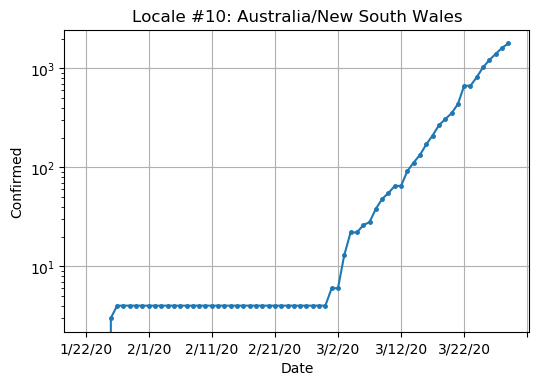

In [23]:
if idx < values.shape[0]:
    while values.iloc[idx, -1] < 1000:
        idx += 1
    plt.figure(dpi=100)
    values.iloc[idx, 1:].plot.line(marker='.', markersize=5, logy=log_metric)
    plt.grid(True)
    plt.title('Locale #{idx}: {locale}'.format(idx=idx + 1, locale=values.iloc[idx, 0]))
    plt.xlabel('Date')
    plt.ylabel(metric.capitalize())
    idx += 1

Stack the data:

In [24]:
values_melt = values.melt(id_vars=['locale'], var_name='date', value_name='value')

In [25]:
values_melt.sample(5)

,locale,date,value
13343,Russia,3/14/20,59
6728,Lithuania,2/17/20,0
6974,"Korea, South",2/18/20,31
7404,China/Jilin,2/20/20,91
433,Paraguay,1/23/20,0


In [26]:
values_melt['date'] = pd.to_datetime(values_melt['date'])

Filter by the minimum required metric value:

In [27]:
values_melt = values_melt.loc[values_melt['value'] >= metric_min[metric]]

Apply log to the metric values, if specified:

In [28]:
if log_metric:
    values_melt['value'] = values_melt['value'].map(np.log10)

In [29]:
values_melt.sample(5)

,locale,date,value
15024,Ecuador,2020-03-21,2.704151
15001,China/Shanghai,2020-03-21,2.579784
9185,China/Tianjin,2020-02-27,2.133539
15743,China/Hainan,2020-03-24,2.225309
5640,China/Shanghai,2020-02-13,2.498311


## Construct Final Datasets

In [30]:
X_schema = pd.DataFrame(columns=['locale', 'date']
                                + ['value_d{}'.format(idx) for idx in range(-days_history + 1, 1)])

In [31]:
y_schema = pd.DataFrame(columns=['locale', 'date']
                                + ['value_d+{}'.format(days_horizon)])

In [32]:
X_train = X_schema.copy()
y_train = y_schema.copy()

In [33]:
X_pred = X_schema.copy()

In [34]:
for locale in sorted(values_melt['locale'].unique()):
    values_melt_locale = values_melt.loc[values_melt['locale'] == locale].sort_values('date')
    
    # Add to training data
    idx = 0
    while idx + (days_history - 1) + days_horizon <= values_melt_locale.shape[0] - 1:
        locale_date_to_append = values_melt_locale.iloc[idx + (days_history - 1), :2].to_dict()
        
        X_train_to_append = dict(zip(X_train.columns[2:], values_melt_locale['value'].iloc[idx : idx + days_history]))
        X_train_to_append.update(locale_date_to_append)
        X_train = X_train.append(X_train_to_append, ignore_index=True)
        
        y_train_to_append = {y_train.columns[-1]: values_melt_locale['value'].iloc[idx + (days_history - 1) + days_horizon]}
        y_train_to_append.update(locale_date_to_append)
        y_train = y_train.append(y_train_to_append, ignore_index=True)
        
        idx += 1
        
    # Add to prediction data
    if days_history <= values_melt_locale.shape[0]:  # Can only predict if we have enough days of history
        locale_date_to_append = values_melt_locale.iloc[-1, :2].to_dict()
        X_pred_to_append = dict(zip(X_pred.columns[2:], values_melt_locale['value'].iloc[-days_history:]))
        X_pred_to_append.update(locale_date_to_append)
        X_pred = X_pred.append(X_pred_to_append, ignore_index=True)

In [35]:
X_train.set_index(['locale', 'date'], inplace=True, verify_integrity=True)
y_train.set_index(['locale', 'date'], inplace=True, verify_integrity=True)
X_pred.set_index(['locale', 'date'], inplace=True, verify_integrity=True)

Check the size of the dataset:

In [36]:
print('The training data has {} samples'.format(X_train.shape[0]))
print('Predictions will be made for {} locales'.format(X_pred.shape[0]))

The training data has 1971 samples
Predictions will be made for 137 locales


In [37]:
X_train.head()

value_d-1  value_d0
locale    date                           
Algeria   2020-03-22   2.143015  2.303196
Argentina 2020-03-21   2.107210  2.198657
          2020-03-22   2.198657  2.424882
Armenia   2020-03-20   2.060698  2.133539
          2020-03-21   2.133539  2.204120

In [38]:
y_train.head()

value_d+7
locale    date                 
Algeria   2020-03-22   2.708421
Argentina 2020-03-21   2.838849
          2020-03-22   2.872156
Armenia   2020-03-20   2.517196
          2020-03-21   2.609594

In [39]:
X_pred.head()

,,value_d-1,value_d0
locale,date,,
Afghanistan,2020-03-29,2.041393,2.079181
Albania,2020-03-29,2.294466,2.326336
Algeria,2020-03-29,2.657056,2.708421
Andorra,2020-03-29,2.488551,2.523746
Argentina,2020-03-29,2.838849,2.872156


## Maching Learning

In [40]:
model = linear_model.LassoCV(
    eps=1e-8,
    fit_intercept=True,
    max_iter=100000,
    tol=1e-6,
    verbose=False,
    n_jobs=-1,
    random_state=random_state,
)

In [41]:
model.fit(X_train.values, y_train.iloc[:, -1])

LassoCV(alphas=None, copy_X=True, cv=None, eps=1e-08, fit_intercept=True,
        max_iter=100000, n_alphas=100, n_jobs=-1, normalize=False,
        positive=False, precompute='auto', random_state=0, selection='cyclic',
        tol=1e-06, verbose=False)

In [42]:
model.coef_

array([-3.62390671,  4.61776393])

In [43]:
model.intercept_

0.08298616077034238

In [44]:
model.alpha_

3.2966384052073052e-09

In [45]:
min(model.alphas_), max(model.alphas_)

(3.2966384052073052e-09, 0.32966384052073044)

In [46]:
model.n_iter_

2140

In [47]:
model.score(X_train.values, y_train.iloc[:, -1])

0.9269366121064638

## Predictions

In [48]:
X_pred['value_d+{}'.format(days_horizon)] = model.predict(X_pred)

In [49]:
if log_metric:
    for col in X_pred.columns:
        X_pred[col] = X_pred[col].map(lambda x: round(10**x))

In [50]:
X_pred

,,value_d-1,value_d0,value_d+7
locale,date,,,
Afghanistan,2020-03-29,110,120,193
Albania,2020-03-29,197,212,324
Algeria,2020-03-29,454,511,914
Andorra,2020-03-29,308,334,523
Argentina,2020-03-29,690,745,1143
Armenia,2020-03-29,407,424,574
Australia/New South Wales,2020-03-29,1617,1791,2999
Australia/Queensland,2020-03-29,625,656,909
Australia/South Australia,2020-03-29,287,299,405
